# Robotics and Motion

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO

import torch

In [2]:
# Paths to the directories
smooth_surface_path = 'Indoor_Robot_Navigation_Data/outputs_2'
rough_surface_path = 'Indoor_Robot_Navigation_Data/outputs'

# Function to load JSON data from a folder
def load_json_files(folder_path):
    data = []
    for file in os.listdir(folder_path):
        if file.endswith(".json"):
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r') as f:
                try:
                    data.append(json.load(f))
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")
    return data

# Load data from both surfaces
smooth_data = load_json_files(smooth_surface_path)
rough_data = load_json_files(rough_surface_path)

In [3]:
# Add surface labels
for record in smooth_data:
    record['surface'] = 'smooth'

for record in rough_data:
    record['surface'] = 'rough'

In [4]:
# Function to extract and normalize 'data' key
def normalize_data(json_data, surface_label):
    all_data = []
    for record in json_data:
        # Extract 'data' and add 'surface' as a label
        for step in record['data']:
            step['surface'] = surface_label
            all_data.append(step)
    return pd.DataFrame(all_data)

# Normalize and combine data
smooth_df = normalize_data(smooth_data, 'smooth')
rough_df = normalize_data(rough_data, 'rough')

# Combine both DataFrames
robot_df = pd.concat([smooth_df, rough_df], ignore_index=True)

# Display dataset overview
print(robot_df.info())
print(robot_df.head())

# Save combined DataFrame to a CSV for inspection
robot_df.to_csv('combined_robot_data.csv', index=False)
print("Combined robot data saved to 'combined_robot_data.csv'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13139 entries, 0 to 13138
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   direction     13139 non-null  object
 1   pose          13139 non-null  object
 2   brake         13139 non-null  int64 
 3   dists         13139 non-null  object
 4   angles        13139 non-null  object
 5   counts_left   13139 non-null  int64 
 6   horn          13139 non-null  int64 
 7   counts_right  13139 non-null  int64 
 8   surface       13139 non-null  object
dtypes: int64(4), object(5)
memory usage: 924.0+ KB
None
  direction                                               pose  brake  \
0        cw  {'seq': 6312, 'stamp': 1.6624593677536015e+18,...      0   
1        cw  {'seq': 6314, 'stamp': 1.6624593680242455e+18,...      0   
2        cw  {'seq': 6316, 'stamp': 1.6624593682817487e+18,...      0   
3        cw  {'seq': 6317, 'stamp': 1.6624593684172943e+18,...      0   
4       

In [5]:
# Load the previously saved CSV to avoid redundant processing
robot_df = pd.read_csv('combined_robot_data.csv')

# Display dataset overview
print(robot_df.info())
print(robot_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13139 entries, 0 to 13138
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   direction     13139 non-null  object
 1   pose          13139 non-null  object
 2   brake         13139 non-null  int64 
 3   dists         13139 non-null  object
 4   angles        13139 non-null  object
 5   counts_left   13139 non-null  int64 
 6   horn          13139 non-null  int64 
 7   counts_right  13139 non-null  int64 
 8   surface       13139 non-null  object
dtypes: int64(4), object(5)
memory usage: 924.0+ KB
None
  direction                                               pose  brake  \
0        cw  {'seq': 6312, 'stamp': 1.6624593677536015e+18,...      0   
1        cw  {'seq': 6314, 'stamp': 1.6624593680242455e+18,...      0   
2        cw  {'seq': 6316, 'stamp': 1.6624593682817487e+18,...      0   
3        cw  {'seq': 6317, 'stamp': 1.6624593684172943e+18,...      0   
4       

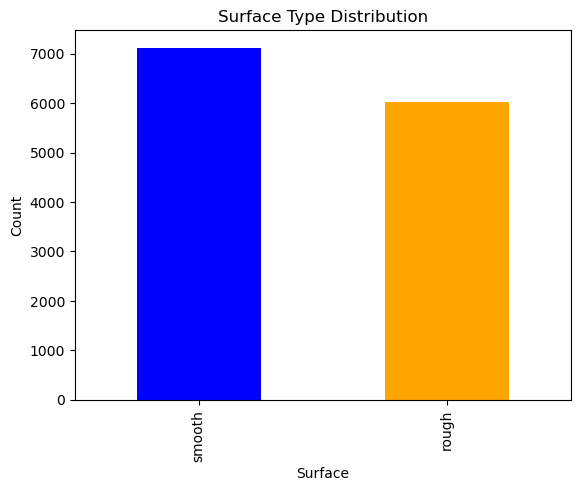

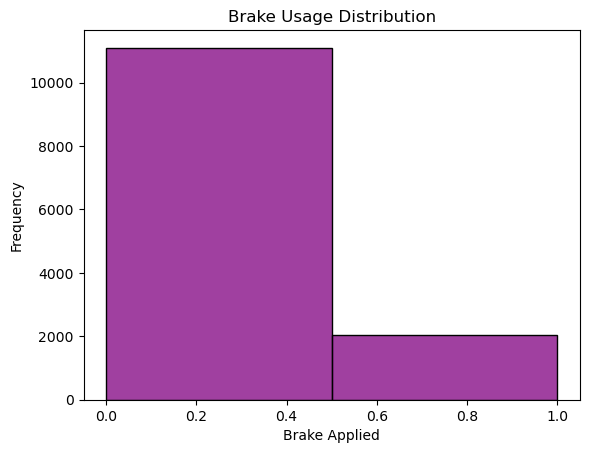

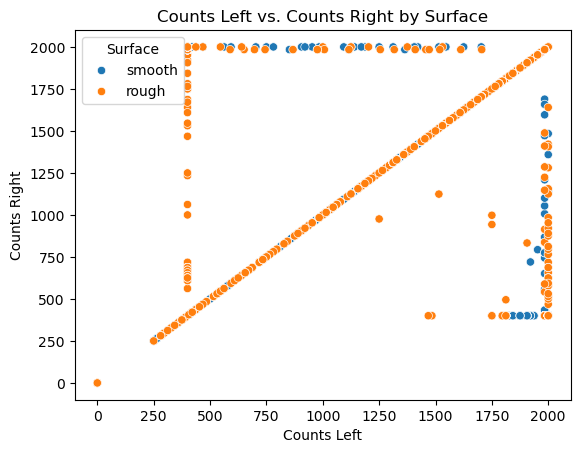

In [6]:
# Distribution of surface labels
robot_df['surface'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Surface Type Distribution")
plt.xlabel("Surface")
plt.ylabel("Count")
plt.show()

# Count distribution of brake usage
sns.histplot(data=robot_df, x='brake', kde=False, bins=2, color='purple')
plt.title("Brake Usage Distribution")
plt.xlabel("Brake Applied")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of counts_left vs. counts_right colored by surface
sns.scatterplot(data=robot_df, x='counts_left', y='counts_right', hue='surface')
plt.title("Counts Left vs. Counts Right by Surface")
plt.xlabel("Counts Left")
plt.ylabel("Counts Right")
plt.legend(title='Surface')
plt.show()

In [7]:
#  Feature Engineering

# Calculate the minimum, mean, and maximum distances
robot_df['min_dist'] = robot_df['dists'].apply(lambda x: min(eval(x)))
robot_df['mean_dist'] = robot_df['dists'].apply(lambda x: np.mean(eval(x)))
robot_df['max_dist'] = robot_df['dists'].apply(lambda x: max(eval(x)))

# Create a speed ratio feature
robot_df['speed_ratio'] = robot_df['counts_left'] / robot_df['counts_right'].replace(0, np.nan)

# Drop unnecessary columns for modeling
robot_df = robot_df.drop(columns=['dists', 'angles', 'pose'], errors='ignore')

In [8]:
# Prepare Data for Modeling

# Encode the surface label
robot_df['surface_encoded'] = robot_df['surface'].map({'smooth': 0, 'rough': 1})

# Features and target
features = ['brake', 'counts_left', 'counts_right', 'min_dist', 'mean_dist', 'max_dist', 'speed_ratio']
X = robot_df[features].fillna(0)  # Replace NaNs if necessary
y = robot_df['surface_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2156
           1       0.87      0.82      0.85      1786

    accuracy                           0.87      3942
   macro avg       0.87      0.86      0.86      3942
weighted avg       0.87      0.87      0.87      3942



In [10]:
# Define Reinforcement Learning Environment

class RobotNavigationEnv(gym.Env):
    def __init__(self, data):
        super(RobotNavigationEnv, self).__init__()
        self.data = data
        self.current_index = 0
        
        # Define state and action space
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(len(data.columns) - 1,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # [0: brake, 1: move forward, 2: turn]
        
        # Define rewards
        self.reward_system = {
            'safe': 10,
            'collision': -100,
            'goal_reached': 50,
            'out_of_bounds': -50
        }
        self.goal_reached = False

    def reset(self):
        """Resets the environment to an initial state."""
        self.current_index = 0
        self.goal_reached = False
        return self.data.iloc[self.current_index, :-1].values

    def step(self, action):
        """Executes one time-step within the environment."""
        if self.goal_reached:
            done = True
            reward = self.reward_system['goal_reached']
            return self.data.iloc[self.current_index, :-1].values, reward, done, {}
        
        # Increment time step
        self.current_index += 1
        if self.current_index >= len(self.data):
            done = True
            reward = self.reward_system['out_of_bounds']
            observation = np.zeros(self.observation_space.shape)
        else:
            done = False
            observation = self.data.iloc[self.current_index, :-1].values
            
            # Simulate reward based on action and current data
            if action == 0:  # Brake
                reward = self.reward_system['safe'] if self.data.iloc[self.current_index]['brake'] == 1 else self.reward_system['collision']
            elif action == 1:  # Move forward
                reward = self.reward_system['safe']
            elif action == 2:  # Turn
                reward = self.reward_system['safe'] if self.data.iloc[self.current_index]['counts_left'] != self.data.iloc[self.current_index]['counts_right'] else self.reward_system['collision']
            else:
                reward = self.reward_system['collision']

        return observation, reward, done, {}

# Example usage
if __name__ == "__main__":
    # Assuming robot_df is already prepared
    env = RobotNavigationEnv(robot_df)

    # Test environment
    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action
        obs, reward, done, info = env.step(action)
        print(f"Obs: {obs}, Reward: {reward}, Done: {done}")


Obs: ['cw' 0 0 0 0 'smooth' 0.187 2.9863271794871795 5.592 nan], Reward: -100, Done: False
Obs: ['cw' 0 0 0 0 'smooth' 0.187 2.9819439918533606 5.616 nan], Reward: -100, Done: False
Obs: ['cw' 0 0 0 0 'smooth' 0.19 2.982647549530761 5.584 nan], Reward: -100, Done: False
Obs: ['cw' 0 0 0 0 'smooth' 0.187 2.960765560165975 5.616 nan], Reward: 10, Done: False
Obs: ['cw' 0 0 0 0 'smooth' 0.187 2.9497500000000003 5.608 nan], Reward: -100, Done: False
Obs: ['cw' 0 406 0 406 'smooth' 0.188 2.961986748216106 5.608 1.0], Reward: -100, Done: False
Obs: ['cw' 0 1734 0 1734 'smooth' 0.187 2.9773966597077246 5.592 1.0], Reward: -100, Done: False
Obs: ['cw' 0 2000 0 2000 'smooth' 0.188 2.9815271794871796 5.616 1.0], Reward: 10, Done: False
Obs: ['cw' 0 2000 0 2000 'smooth' 0.187 2.994472746331237 5.584 1.0], Reward: -100, Done: False
Obs: ['cw' 0 2000 0 2000 'smooth' 0.187 3.0119604060913705 5.6 1.0], Reward: 10, Done: False
Obs: ['cw' 0 2000 0 2000 'smooth' 0.187 2.9796966873706006 5.608 1.0], Rewa

In [ ]:
# Train Reinforcement Learning Model

# Create the environment
env = RobotNavigationEnv(robot_df)

# Train a PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Save the model
model.save("robot_navigation_model")

# Evaluate the model
model = PPO.load("robot_navigation_model")
obs = env.reset()
for _ in range(100):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    print(f"Obs: {obs}, Reward: {reward}, Done: {done}")
    if done:
        break

In [ ]:
# Visualization

plt.plot(robot_df['pose'].apply(lambda x: x[0]), robot_df['pose'].apply(lambda x: x[1]))
plt.title("Navigation Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()